In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb

sys.path.append('../')
sys.path.append('/rumi/shams/abe/GitHub/ipage-down/')

from util import *
import ipage_down as ipd

Here, I aim to do _hyper-geometric test_ on enriched genesets (iPAGE results) in CRISPR screening experiment (Rho scores) to test hyper/hypo methylation enrichment. 

### Load data

Load `hl60` CRISPRi-screen data

In [2]:
data = load_data(screens=True)

In [3]:
data['hl60'].keys()

dict_keys(['exp1_DAC_rho', 'exp1_DAC_gamma', 'exp2_DAC_rho', 'exp2_DAC_gamma', 'exp2_GSK_rho', 'exp2_GSK_gamma'])

Load iPAGE results into python - using my [ipage-down](https://github.com/abearab/ipage-down) python script 

In [4]:
data['hl60']['exp1_DAC_rho_page'] = ipd.make_ipage_run_dict('../CRISPRi-screen/hl60_exp1_DAC_rho_delta_phenotype/')
data['hl60']['exp2_DAC_rho_page'] = ipd.make_ipage_run_dict('../CRISPRi-screen/hl60_exp2_DAC_rho_delta_phenotype/')

In [ ]:
# https://gseapy.readthedocs.io/en/latest/gseapy_tutorial.html

### Run the hypergeom test





For this matter, we have:

    ○ N = # of all genes 
    ○ n/A = # of metylated genes OR enriched pathway's genes 
    ○ x = # of genes in n and A overlap 

https://github.com/JohnDeJesus22/DataScienceMathFunctions/blob/master/hypergeometricfunctions.py#L38

In [45]:
def hypergeom_pmf(N, A, n, x):
    '''
    Probability Mass Function for Hypergeometric Distribution
    :param N: population size
    :param A: total number of desired items in N
    :param n: number of draws made from N
    :param x: number of desired items in our draw of n items
    :returns: PMF computed at x
    '''
    Achoosex = comb(A,x)
    NAchoosenx = comb(N-A, n-x)
    Nchoosen = comb(N,n)
    
    return (Achoosex)*NAchoosenx/Nchoosen
    
    
def hypergeom_plot(N, A, n):
    '''
    Visualization of Hypergeometric Distribution for given parameters
    '''
    x = np.arange(0, n+1)
    y = [hypergeom_pmf(N, A, n, x) for x in range(n+1)]
    plt.plot(x, y, 'bo')
    plt.vlines(x, 0, y, lw=2)
    plt.xlabel('# of desired items in our draw')
    plt.ylabel('Probablities')
    plt.title('Hypergeometric Distribution Plot')
    plt.show()


def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 


def hypergeom_pw(pw):
    '''
    Run Hypergeometric test for given pathway
    '''
    res = list()
    for mtyl in [hyper, hypo]:
        N = 20000
        A = len(mtyl)
        n = len(pw)
        x = len(intersection(mtyl, pw))
        res.append(hypergeom_pmf(N, A, n, x))
    return res 


def run_hypergeom(page):
    '''
    Return Hypergeometric test for all pathways in a ipage run 
    '''
    hyper, hypo = [set(list(mtyl.name)) for mtyl in two_sided_mtyl()]
    results = [[pw,hypergeom_pw(page[gs_clust]['annotations'][pw]['genes'])] for gs_clust in page for pw in page[gs_clust]['annotations']]
    out = pd.DataFrame([r[1] for r in results],columns=['hyper', 'hypo'],index=[r[0] for r in results]).dropna()
    
    return out 

In [96]:
res1 = run_hypergeom(data['hl60']['exp1_DAC_rho_page'])
res2 = run_hypergeom(data['hl60']['exp2_DAC_rho_page'])

# pws = list(set(res1.index) & set(res1.index))
# res1= res1.loc[pws,]
# res2= res2.loc[pws,]

/rumi/shams/abe/anaconda3/envs/deseq/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/rumi/shams/abe/anaconda3/envs/deseq/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  


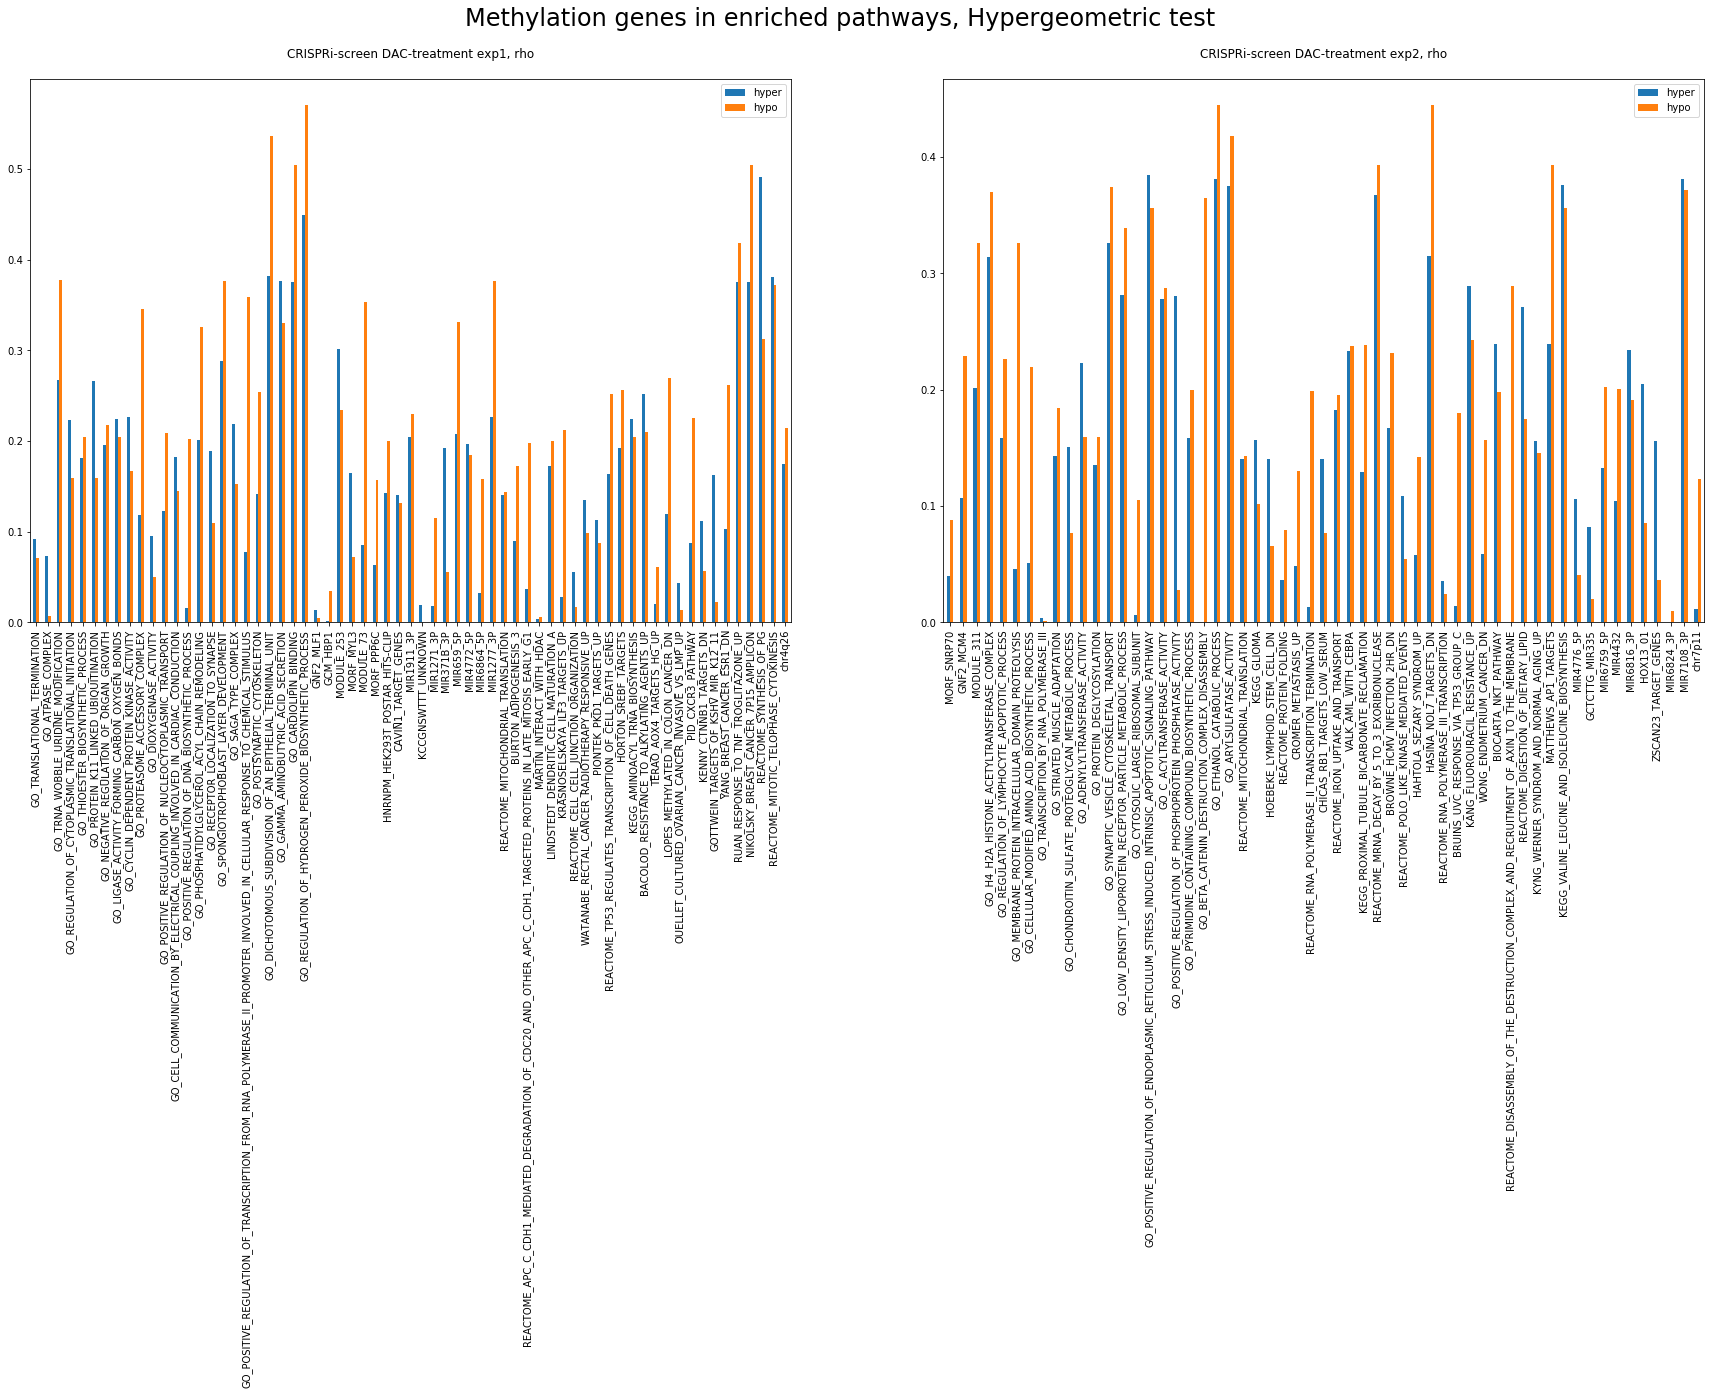

In [104]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))

res1.plot.bar(title='CRISPRi-screen DAC-treatment exp1, rho\n',ax=axes[0])
# axes[0].axes.get_xaxis().set_visible(False)

res2.plot.bar(title='CRISPRi-screen DAC-treatment exp2, rho\n',ax=axes[1])

plt.suptitle('Methylation genes in enriched pathways, Hypergeometric test\n\n',size=24)

plt.xticks(rotation=90)
plt.show()

fig.savefig("hyper-geometric-test.pdf", bbox_inches='tight')